# Auto Encoder

オートエンコーダ。

入力したものをそのまま出力するようなニューラルネットワーク。  
**encoder**と**decoder**の2つの部分からなる。

- encoder：入力を低次元のベクトルに変換する
- decoder：encoderの出力を元の次元に戻す

低次元に圧縮したベクトルを潜在変数と呼ぶ。

<br>

MNISTを使って、何ができるか試してみる

In [1]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from IPython.display import display
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
mnist = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(mnist, batch_size=64, shuffle=True)

def write(model, n_images, dataloader, width=512):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(dataloader))
        x = x.view(x.size(0), -1)[:n_images].to(device)
        y = model(x)
    x = x.view(n_images, 1, 28, 28).cpu()
    y = y.view(n_images, 1, 28, 28).cpu()
    f = width // n_images
    x = transforms.Resize((f))(x)
    y = transforms.Resize((f))(y)
    grid = torchvision.utils.make_grid(torch.cat([x, y], dim=0), nrow=n_images)
    img = transforms.functional.to_pil_image(grid)
    display(img)

## Auto Encoder

ノーマルなオートエンコーダ。

活用例
- ノイズ削除
- 次元削減
- 異常検知

## モデル用意

`z_dim`: 潜在変数の次元数

In [3]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, z_dim),
        )
    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.net(x)

class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

学習  
入力と出力の平均二乗誤差を損失とする

In [4]:
def train(model, n_epochs, dataloader, critetion, optimizer):
    model.train()
    for epoch in range(n_epochs):
        for x, _ in dataloader:
            optimizer.zero_grad()
            x = x.view(x.size(0), -1).to(device)
            y = model(x)
            loss = critetion(y, x)
            loss.backward()
            optimizer.step()
        print(f'{epoch+1:>3}epoch, loss:{loss.item()}')

In [5]:
z_dim = 10
encoder = Encoder(z_dim).to(device)
decoder = Decoder(z_dim).to(device)
ae = AutoEncoder(encoder, decoder).to(device)

n_epochs = 5
critetion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

train(ae, n_epochs, dataloader, critetion, optimizer)

  1epoch, loss:0.023530196398496628
  2epoch, loss:0.019999569281935692
  3epoch, loss:0.018270596861839294
  4epoch, loss:0.015493945218622684
  5epoch, loss:0.016203664243221283


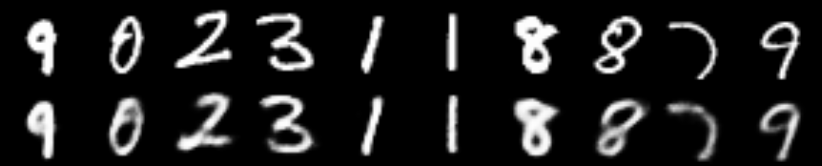

In [6]:
write(ae, 10, dataloader, width=800)

上が入力、下が出力。

### ノイズ削除

一度低次元に圧縮することで情報量が減るため、ノイズ削除に使える。  
上の例にもある通り、下の方がぼやけているのが分かる。

潜在変数の次元数を減らすと、もっとぼやける

  1epoch, loss:0.04392557218670845
  2epoch, loss:0.045432060956954956
  3epoch, loss:0.040512565523386
  4epoch, loss:0.03967355936765671
  5epoch, loss:0.03972507268190384


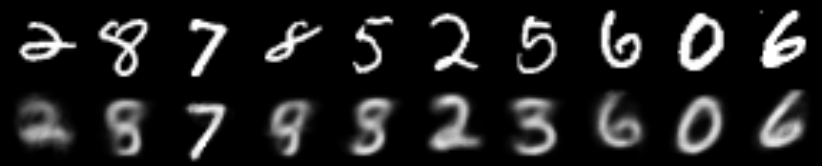

In [7]:
z_dim = 2
encoder = Encoder(z_dim).to(device)
decoder = Decoder(z_dim).to(device)
ae = AutoEncoder(encoder, decoder).to(device)

n_epochs = 5
critetion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

train(ae, n_epochs, dataloader, critetion, optimizer)

write(ae, 10, dataloader, width=800)

### 次元削減

encoderは入力を低次元に圧縮しているので、そこだけ使えば次元削減ができる。

先程学習したencoderを使って、二次元の潜在変数をプロットする。

In [8]:
images = []
labels = []
ae.eval()
with torch.no_grad():
    for x, label in dataloader:
        x = x.view(x.size(0), -1).to(device)
        z = ae.encoder(x)
        images.append(z.cpu())
        labels.append(label)
images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)

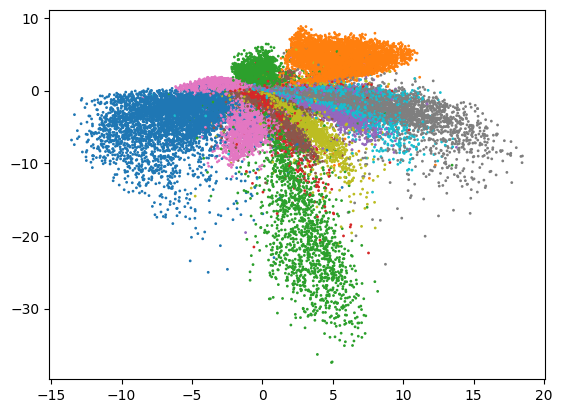

In [9]:
plt.scatter(images[:, 0], images[:, 1], c=labels, s=1, cmap='tab10');

数字ごとに特徴が表れているのが分かる

## 異常検知